In [1]:
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
import d3p
from twinify.napsu_mq.napsu_mq import NapsuMQModel
from twinify.napsu_mq import rubins_rules as rubin
from twinify.napsu_mq import marginal_query
from twinify.napsu_mq.markov_network import MarkovNetwork
from twinify.napsu_mq import maximum_entropy_inference as mei
from twinify.napsu_mq import privacy_accounting
from tests.napsu_mq.binary_logistic_regression_generator import BinaryLogisticRegressionDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from tqdm import tqdm

In [2]:
n = 2000
d = 4
n_syn_datasets = 100
n_syn_dataset = n

epsilon = 1.0
delta = n**(-2)

conf_levels = np.linspace(0.05, 0.95, 19)
true_params = jnp.array((0.4, 0.3, 0.0))


def gen_data(rng):
    data_gen = BinaryLogisticRegressionDataGenerator(true_params)
    data = data_gen.generate_data(n, rng)
    x_values = data_gen.x_values
    values_by_feature = data_gen.values_by_feature

    return data, x_values, values_by_feature

def get_dp_suff_stat(rng, queries, data):
    suff_stat = jnp.sum(queries.flatten()(data), axis=0)
    sensitivity = np.sqrt(suff_stat.shape[0])
    sigma_DP = privacy_accounting.sigma(epsilon, delta, sensitivity)
    dp_suff_stat = suff_stat + sigma_DP * jax.random.normal(key=rng, shape=suff_stat.shape)
    return dp_suff_stat, sigma_DP

def record(ci, conf_level, dim, repeat_ind):
    return {
        "has_coverage": int(ci[0] <= true_params[dim].item() <= ci[1]),
        "conf_level": conf_level,
        "dim": dim,
        "repeat_ind": repeat_ind
    }


def logistic_regression(datasets, col_to_predict=None, add_constant=True):
    m, n, d = datasets.shape
    if col_to_predict is None: col_to_predict = d - 1
    feature_cols = set(range(d))
    feature_cols.remove(col_to_predict)
    feature_cols = list(feature_cols)

    num_coefs = d if add_constant else d - 1
    q = np.zeros((m, num_coefs))
    u = np.zeros((m, num_coefs))
    for i in range(m):
        dataset = datasets[i,:,:]
        feature_array = sm.add_constant(dataset[:, feature_cols], has_constant="add") if add_constant else dataset[:, feature_cols]
        y_array = dataset[:, col_to_predict]

        try:
            syn_model = sm.GLM(y_array, feature_array, family=sm.families.Binomial())
            syn_result = syn_model.fit()

            q[i, :] = syn_result.params
            u[i, :] = syn_result.bse**2
        except PerfectSeparationError:
            q[i, :] = np.full(num_coefs, np.nan)
            u[i, :] = np.full(num_coefs, np.nan)

    return q, u

In [5]:
n_repeats = 50
records = []
rng = d3p.random.PRNGKey(74249069)
rngs = d3p.random.split(rng, n_repeats)

for i in tqdm(range(n_repeats)):
    data_rng, inference_rng, sampling_rng = d3p.random.split(rngs[i], 3)
    data_rng = d3p.random.convert_to_jax_rng_key(data_rng)
    
    data, x_values, values_by_feature = gen_data(data_rng)
    data = pd.DataFrame(data, dtype="category")

    model = NapsuMQModel(required_marginals=[tuple(range(d))], use_laplace_approximation=False)
    result = model.fit(
        data=data,
        rng=inference_rng,
        epsilon=epsilon,
        delta=delta,
        query_sets=[tuple(range(d))]
    )

    synthetic_dfs = result.generate(
        rng=sampling_rng, 
        num_data_per_parameter_sample=n_syn_dataset, 
        num_parameter_samples=n_syn_datasets,
        single_dataframe=False
    )

    syn_datasets = np.stack(synthetic_dfs, axis=0).astype(int)

    q, u = logistic_regression(syn_datasets, add_constant=False)
    for j in range(d - 1):
        for conf_level in conf_levels:
            qi = q[:,j]
            ui = u[:,j]
            inds = (np.isfinite(qi) & np.isfinite(ui))
            qi = qi[inds]
            ui = ui[inds]
            ci = rubin.conf_int(qi, ui, conf_level)
            records.append(record(ci, conf_level, j, i))


df = pd.DataFrame.from_records(records)

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 7067.07it/s]


4it [00:00, 8733.58it/s]


2it [00:00, 8848.74it/s]


4it [00:00, 15563.28it/s]


8it [00:00, 11362.83it/s]


8it [00:00, 10502.17it/s]


4it [00:00, 19065.02it/s]


8it [00:00, 16031.74it/s]


8it [00:00, 16702.06it/s]


4it [00:00, 17604.63it/s]


2it [00:00, 22017.34it/s]


4it [00:00, 20435.10it/s]


16it [00:00, 6424.98it/s]


2it [00:00, 9088.42it/s]


2it [00:00, 10538.45it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 460.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 839.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47662.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 51690.37it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 369.97it/s, 7 steps of size 2.94e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4321.92it/s, 7 steps of size 2.47e-01. acc. prob=0.

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 372.37it/s, 15 steps of size 2.45e-01. acc. prob=0.88]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4305.78it/s, 31 steps of size 1.71e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4239.90it/s, 7 steps of size 2.80e-01. acc. prob=0.87]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 36631.48it/s]


4it [00:00, 38746.46it/s]


2it [00:00, 16513.01it/s]


4it [00:00, 40524.68it/s]


8it [00:00, 29407.92it/s]


8it [00:00, 27125.65it/s]


4it [00:00, 32704.12it/s]




sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 366.56it/s, 7 steps of size 3.29e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4326.62it/s, 7 steps of size 2.67e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4013.51it/s, 7 steps of size 2.63e-01. acc. prob=0.92]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 34239.22it/s]


4it [00:00, 44384.17it/s]


2it [00:00, 22429.43it/s]


4it [00:00, 28777.39it/s]


8it [00:00, 29001.24it/s]


8it [00:00, 26694.06it/s]


4it [00:00, 38391.80it/s]




sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4011.05it/s, 7 steps of size 1.37e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4104.36it/s, 7 steps of size 2.17e-01. acc. prob=0.88]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 40329.85it/s]


4it [00:00, 37449.14it/s]


2it [00:00, 42799.02it/s]


4it [00:00, 32017.59it/s]


8it [00:00, 31775.03it/s]


8it [00:00, 27776.85it/s]


4it [00:00, 46474.28it/s]


8it [00:00, 11765.23it/s]


8it [00:00, 18957.31it/s]


4it [00:00, 28339.89it/s]


2it [00:00, 33288.13it/s]


4it [00:00, 36002.61it/s]


16it [00:00, 18708.91it/s]


2it [00:00, 17810.21it/s]


2it 

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4127.30it/s, 7 steps of size 2.12e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4027.91it/s, 7 steps of size 2.69e-01. acc. prob=0.86]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 31242.49it/s]


4it [00:00, 32513.98it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 33554.43it/s]


8it [00:00, 29641.72it/s]


8it [00:00, 23061.47it/s]


4it [00:00, 47527.52it/s]


8it [00:00, 35848.75it/s]


8it [00:00, 29959.31it/s]


4it [00:00, 48913.17it/s]


2it [00:00, 19239.93it/s]


4it [00:00, 37035.80it/s]


16it [00:00, 20541.43it/s]


2it [00:00, 38479.85it/s]


2it 

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3953.26it/s, 79 steps of size 1.59e-01. acc. prob=0.90]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 40721.40it/s]


4it [00:00, 33893.37it/s]


2it [00:00, 34379.54it/s]


4it [00:00, 39945.75it/s]


8it [00:00, 27191.60it/s]


8it [00:00, 31011.49it/s]


4it [00:00, 40427.03it/s]


8it [00:00, 33454.07it/s]


8it [00:00, 23317.88it/s]


4it [00:00, 26843.55it/s]


2it [00:00, 34100.03it/s]


4it [00:00, 15679.64it/s]


16it [00:00, 17655.58it/s]


2it [00:00, 28149.69it/s]


2it [00:00, 36954.22it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:0

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4258.93it/s, 7 steps of size 3.50e-01. acc. prob=0.86]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 35098.78it/s]


4it [00:00, 39199.10it/s]


2it [00:00, 16131.94it/s]


4it [00:00, 32832.13it/s]


8it [00:00, 31595.51it/s]


8it [00:00, 24403.22it/s]


4it [00:00, 36472.21it/s]


8it [00:00, 33621.68it/s]


8it [00:00, 38657.18it/s]


4it [00:00, 48770.98it/s]


2it [00:00, 19065.02it/s]


4it [00:00, 40820.48it/s]


16it [00:00, 18941.25it/s]


2it [00:00, 19784.45it/s]


2it [00:00, 36954.22it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:0

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4130.63it/s, 7 steps of size 2.58e-01. acc. prob=0.86]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 42048.16it/s]


4it [00:00, 43464.29it/s]


2it [00:00, 40721.40it/s]


4it [00:00, 35469.80it/s]


8it [00:00, 30311.14it/s]


8it [00:00, 16400.02it/s]


4it [00:00, 42048.16it/s]


8it [00:00, 33454.07it/s]


8it [00:00, 34344.35it/s]


4it [00:00, 48913.17it/s]


2it [00:00, 28244.47it/s]


4it [00:00, 19714.71it/s]


16it [00:00, 19086.71it/s]


2it [00:00, 20610.83it/s]


2it [00:00, 37786.52it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 32768.00it/s]


4it [00:00, 29433.71it/s]


2it [00:00, 26630.50it/s]


4it [00:00, 45964.98it/s]


8it [00:00, 33058.55it/s]


8it [00:00, 25003.30it/s]


4it [00:00, 43919.41it/s]


8it [00:00, 37365.74it/s]


8it [00:00, 15155.57it/s]


4it [00:00, 40524.68it/s]


2it [00:00, 35696.20it/s]


4it [00:00, 18872.01it/s]


16it [00:00, 16545.58it/s]


2it [00:00, 38479.85it/s]


2it [00:00, 34379.54it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 977.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 32768.00it/s]


4it [00:00, 45466.71it/s]


2it [00:00, 44384.17it/s]


4it [00:00, 21481.71it/s]


8it [00:00, 35696.20it/s]


8it [00:00, 24690.53it/s]


4it [00:00, 30338.55it/s]


8it [00:00, 18396.07it/s]


8it [00:00, 28484.24it/s]


4it [00:00, 45100.04it/s]


2it [00:00, 35098.78it/s]


4it [00:00, 27822.91it/s]


16it [00:00, 18451.71it/s]


2it [00:00, 28532.68it/s]


2it [00:00, 9000.65it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 860.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<0

4it [00:00, 30066.70it/s]


2it [00:00, 11634.69it/s]


4it [00:00, 26173.50it/s]


16it [00:00, 16460.35it/s]


2it [00:00, 34663.67it/s]


2it [00:00, 33961.98it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 889.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59074.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44620.26it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 371.36it/s, 7 steps of size 2.59e-01. acc. prob=0.87]

sample: 100%|████████████████

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 370.58it/s, 3 steps of size 2.73e-01. acc. prob=0.86]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4142.85it/s, 7 steps of size 2.26e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4219.67it/s, 7 steps of size 2.40e-01. acc. prob=0.86]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 26843.55it/s]


4it [00:00, 34735.44it/s]


2it [00:00, 36954.22it/s]


4it [00:00, 46995.00it/s]


8it [00:00, 32140.26it/s]


8it [00:00, 25324.10it/s]


4it [00:00, 46091.25it/s]




sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 356.52it/s, 7 steps of size 2.54e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4026.12it/s, 7 steps of size 2.59e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4001.26it/s, 7 steps of size 2.57e-01. acc. prob=0.87]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 38479.85it/s]


4it [00:00, 42581.77it/s]


2it [00:00, 19418.07it/s]


4it [00:00, 37365.74it/s]


8it [00:00, 36041.28it/s]


8it [00:00, 24122.52it/s]


4it [00:00, 28387.84it/s]




sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 364.66it/s, 7 steps of size 3.07e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3805.13it/s, 7 steps of size 2.83e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4246.87it/s, 7 steps of size 3.18e-01. acc. prob=0.88]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 19622.47it/s]


4it [00:00, 13992.67it/s]


2it [00:00, 25266.89it/s]


4it [00:00, 22764.20it/s]


8it [00:00, 23109.11it/s]


8it [00:00, 25172.12it/s]


4it [00:00, 43464.29it/s]




sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4353.36it/s, 7 steps of size 3.40e-01. acc. prob=0.87]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4390.16it/s, 15 steps of size 3.35e-01. acc. prob=0.86]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 35172.36it/s]


4it [00:00, 35098.78it/s]


2it [00:00, 27324.46it/s]


4it [00:00, 46091.25it/s]


8it [00:00, 27776.85it/s]


8it [00:00, 21931.00it/s]


4it [00:00, 4419.71it/s]


8it [00:00, 12841.34it/s]


8it [00:00, 15203.64it/s]


4it [00:00, 13888.42it/s]


2it [00:00, 29852.70it/s]


4it [00:00, 25343.23it/s]


16it [00:00, 11252.32it/s]


2it [00:00, 26379.27it/s]


2it [

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3784.26it/s, 7 steps of size 1.10e-01. acc. prob=0.84]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3929.97it/s, 7 steps of size 1.37e-01. acc. prob=0.90]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 40041.09it/s]


4it [00:00, 39199.10it/s]


2it [00:00, 27776.85it/s]


4it [00:00, 44384.17it/s]


8it [00:00, 28679.00it/s]


8it [00:00, 33189.35it/s]


4it [00:00, 36631.48it/s]


8it [00:00, 23045.63it/s]


8it [00:00, 9215.72it/s]


4it [00:00, 34169.48it/s]


2it [00:00, 10010.27it/s]


4it [00:00, 18497.48it/s]


16it [00:00, 15462.87it/s]


2it [00:00, 25420.02it/s]


2it [

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4254.77it/s, 7 steps of size 2.67e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4398.61it/s, 3 steps of size 2.94e-01. acc. prob=0.90]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 31536.12it/s]


4it [00:00, 48072.25it/s]


2it [00:00, 16545.58it/s]


4it [00:00, 45964.98it/s]


8it [00:00, 11765.23it/s]


8it [00:00, 14893.22it/s]


4it [00:00, 26504.29it/s]


8it [00:00, 21236.98it/s]


8it [00:00, 34030.86it/s]


4it [00:00, 28976.19it/s]


2it [00:00, 39199.10it/s]


4it [00:00, 27822.91it/s]


16it [00:00, 15970.70it/s]


2it [00:00, 33420.75it/s]


2it 

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4181.46it/s, 7 steps of size 2.91e-01. acc. prob=0.85]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 38836.15it/s]


4it [00:00, 40721.40it/s]


2it [00:00, 16677.15it/s]


4it [00:00, 28826.83it/s]


8it [00:00, 33222.21it/s]


8it [00:00, 26071.82it/s]


4it [00:00, 33621.68it/s]


8it [00:00, 13427.14it/s]


8it [00:00, 26843.55it/s]


4it [00:00, 37617.08it/s]


2it [00:00, 29746.84it/s]


4it [00:00, 37035.80it/s]


16it [00:00, 16685.45it/s]


2it [00:00, 33961.98it/s]


2it [00:00, 41527.76it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:0

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3867.34it/s, 7 steps of size 1.76e-01. acc. prob=0.88]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 31242.49it/s]


4it [00:00, 43018.50it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 11667.05it/s]


8it [00:00, 16777.22it/s]


8it [00:00, 18914.56it/s]


4it [00:00, 44034.69it/s]


8it [00:00, 25712.21it/s]


8it [00:00, 33655.40it/s]


4it [00:00, 44384.17it/s]


2it [00:00, 27776.85it/s]


4it [00:00, 40820.48it/s]


16it [00:00, 16631.69it/s]


2it [00:00, 10058.28it/s]


2it [00:00, 19784.45it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:0

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3849.83it/s, 7 steps of size 1.09e-01. acc. prob=0.90]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 40041.09it/s]


4it [00:00, 47662.55it/s]


2it [00:00, 15621.24it/s]


4it [00:00, 39290.90it/s]


8it [00:00, 31388.62it/s]


8it [00:00, 27571.43it/s]


4it [00:00, 44979.13it/s]


8it [00:00, 22998.24it/s]


8it [00:00, 24018.92it/s]


4it [00:00, 35772.32it/s]


2it [00:00, 14588.88it/s]


4it [00:00, 40041.09it/s]


16it [00:00, 17758.37it/s]


2it [00:00, 16384.00it/s]


2it [00:00, 24105.20it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:0

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 35620.42it/s]


4it [00:00, 49490.31it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 46995.00it/s]


8it [00:00, 32232.88it/s]


8it [00:00, 24929.00it/s]


4it [00:00, 37701.61it/s]


8it [00:00, 14413.42it/s]


8it [00:00, 28460.08it/s]


4it [00:00, 37786.52it/s]


2it [00:00, 34379.54it/s]


4it [00:00, 45839.39it/s]


16it [00:00, 16178.61it/s]


2it [00:00, 40136.88it/s]


2it [00:00, 28926.23it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 911.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 34450.14it/s]


4it [00:00, 45964.98it/s]


2it [00:00, 9653.17it/s]


4it [00:00, 38130.04it/s]


8it [00:00, 37871.82it/s]


8it [00:00, 30643.32it/s]


4it [00:00, 33288.13it/s]


8it [00:00, 36671.51it/s]


8it [00:00, 22354.72it/s]


4it [00:00, 23967.45it/s]


2it [00:00, 28926.23it/s]


4it [00:00, 30727.50it/s]


16it [00:00, 15090.82it/s]


2it [00:00, 36954.22it/s]


2it [00:00, 37117.73it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 918.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<0

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 37035.80it/s]


4it [00:00, 34521.02it/s]


2it [00:00, 33825.03it/s]


4it [00:00, 41734.37it/s]


8it [00:00, 35062.10it/s]


8it [00:00, 31388.62it/s]


4it [00:00, 42908.48it/s]


8it [00:00, 27985.35it/s]


8it [00:00, 13791.38it/s]


4it [00:00, 21592.30it/s]


2it [00:00, 13595.80it/s]


4it [00:00, 40427.03it/s]


16it [00:00, 15325.16it/s]


2it [00:00, 23563.51it/s]


2it [00:00, 31775.03it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 907.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 41630.81it/s]


4it [00:00, 32832.13it/s]


2it [00:00, 14614.30it/s]


4it [00:00, 48770.98it/s]


8it [00:00, 28876.45it/s]


8it [00:00, 28173.33it/s]


4it [00:00, 25771.45it/s]


8it [00:00, 7720.76it/s]


8it [00:00, 22610.80it/s]


4it [00:00, 38391.80it/s]


2it [00:00, 37617.08it/s]


4it [00:00, 18275.83it/s]


16it [00:00, 19000.24it/s]


2it [00:00, 32263.88it/s]


2it [00:00, 37617.08it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 860.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58254.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44996.36it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 368.84it/s, 7 steps of size 2.26e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4185.91it/s, 7 steps of size 2.09e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4188.37it/s, 7 steps of size 3.15e-01. acc. prob=0.

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 360.72it/s, 7 steps of size 5.14e-02. acc. prob=0.86]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3223.99it/s, 7 steps of size 5.12e-02. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3491.22it/s, 7 steps of size 9.63e-02. acc. prob=0.88]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 23696.63it/s]


4it [00:00, 44384.17it/s]


2it [00:00, 12905.55it/s]


4it [00:00, 47527.52it/s]


8it [00:00, 34807.50it/s]


8it [00:00, 17093.44it/s]


4it [00:00, 35098.78it/s]




sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 369.72it/s, 3 steps of size 2.81e-01. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4185.65it/s, 7 steps of size 1.80e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4164.57it/s, 7 steps of size 2.14e-01. acc. prob=0.89]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 34450.14it/s]


4it [00:00, 38479.85it/s]


2it [00:00, 16100.98it/s]


4it [00:00, 43919.41it/s]


8it [00:00, 32800.03it/s]


8it [00:00, 37957.50it/s]


4it [00:00, 39199.10it/s]




sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 369.70it/s, 7 steps of size 3.67e-01. acc. prob=0.83]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4266.17it/s, 7 steps of size 2.87e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4161.07it/s, 7 steps of size 2.91e-01. acc. prob=0.91]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 32832.13it/s]


4it [00:00, 36002.61it/s]


2it [00:00, 34521.02it/s]


4it [00:00, 26296.58it/s]


8it [00:00, 11328.30it/s]


8it [00:00, 22779.66it/s]


4it [00:00, 41630.81it/s]




sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4258.81it/s, 7 steps of size 2.15e-01. acc. prob=0.89]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4245.48it/s, 15 steps of size 2.50e-01. acc. prob=0.87]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 15797.76it/s]


4it [00:00, 36954.22it/s]


2it [00:00, 37282.70it/s]


4it [00:00, 29852.70it/s]


8it [00:00, 25247.88it/s]


8it [00:00, 21859.56it/s]


4it [00:00, 29852.70it/s]


8it [00:00, 17688.16it/s]


8it [00:00, 26483.37it/s]


4it [00:00, 27016.45it/s]


2it [00:00, 27776.85it/s]


4it [00:00, 22733.36it/s]


16it [00:00, 12429.87it/s]


2it [00:00, 16777.22it/s]


2it 

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4358.45it/s, 23 steps of size 2.96e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4340.18it/s, 7 steps of size 2.95e-01. acc. prob=0.88]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 31476.95it/s]


4it [00:00, 36711.63it/s]


2it [00:00, 34663.67it/s]


4it [00:00, 31476.95it/s]


8it [00:00, 36196.80it/s]


8it [00:00, 23317.88it/s]


4it [00:00, 42581.77it/s]


8it [00:00, 24546.04it/s]


8it [00:00, 24174.66it/s]


4it [00:00, 7752.87it/s]


2it [00:00, 14926.35it/s]


4it [00:00, 41630.81it/s]


16it [00:00, 19423.69it/s]


2it [00:00, 31300.78it/s]


2it [

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4086.98it/s, 7 steps of size 2.08e-01. acc. prob=0.86]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 38130.04it/s]


4it [00:00, 35098.78it/s]


2it [00:00, 39945.75it/s]


4it [00:00, 30559.59it/s]


8it [00:00, 35544.95it/s]


8it [00:00, 34344.35it/s]


4it [00:00, 32513.98it/s]


8it [00:00, 22534.88it/s]


8it [00:00, 26951.35it/s]


4it [00:00, 31011.49it/s]


2it [00:00, 36314.32it/s]


4it [00:00, 46603.38it/s]


16it [00:00, 14532.02it/s]


2it [00:00, 39945.75it/s]


2it [00:00, 29330.80it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:0

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4106.77it/s, 7 steps of size 2.89e-01. acc. prob=0.88]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 34239.22it/s]


4it [00:00, 39107.73it/s]


2it [00:00, 31775.03it/s]


4it [00:00, 40329.85it/s]


8it [00:00, 27892.30it/s]


8it [00:00, 28556.96it/s]


4it [00:00, 23237.14it/s]


8it [00:00, 27776.85it/s]


8it [00:00, 22162.77it/s]


4it [00:00, 39568.91it/s]


2it [00:00, 15768.06it/s]


4it [00:00, 45466.71it/s]


16it [00:00, 11860.88it/s]


2it [00:00, 30727.50it/s]


2it [00:00, 30840.47it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:0

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 37035.80it/s]


4it [00:00, 39290.90it/s]


2it [00:00, 14588.88it/s]


4it [00:00, 41734.37it/s]


8it [00:00, 34627.90it/s]


8it [00:00, 25078.05it/s]


4it [00:00, 23269.37it/s]


8it [00:00, 26757.92it/s]


8it [00:00, 19328.59it/s]


4it [00:00, 38130.04it/s]


2it [00:00, 15477.14it/s]


4it [00:00, 32832.13it/s]


16it [00:00, 19468.77it/s]


2it [00:00, 33420.75it/s]


2it [00:00, 17084.74it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 930.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 36393.09it/s]


4it [00:00, 38130.04it/s]


2it [00:00, 37117.73it/s]


4it [00:00, 29433.71it/s]


8it [00:00, 14039.51it/s]


8it [00:00, 23814.36it/s]


4it [00:00, 41221.66it/s]


8it [00:00, 29203.16it/s]


8it [00:00, 17358.73it/s]


4it [00:00, 30783.88it/s]


2it [00:00, 30283.78it/s]


4it [00:00, 30954.27it/s]


16it [00:00, 14896.53it/s]


2it [00:00, 34379.54it/s]


2it [00:00, 25040.62it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 792.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<

2it [00:00, 39199.10it/s]


4it [00:00, 36002.61it/s]


8it [00:00, 20945.34it/s]


8it [00:00, 24708.71it/s]


4it [00:00, 43464.29it/s]


8it [00:00, 36393.09it/s]


8it [00:00, 26929.72it/s]


4it [00:00, 42581.77it/s]


2it [00:00, 27060.03it/s]


4it [00:00, 39290.90it/s]


16it [00:00, 12529.66it/s]


2it [00:00, 19831.22it/s]


2it [00:00, 30283.78it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 910.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47778.89it/s]

sample: 100%|█████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47662.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45134.71it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 368.88it/s, 7 steps of size 2.26e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4245.33it/s, 7 steps of size 2.43e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4161.86it/s, 7 steps of size 2.16e-01. acc. prob=0.

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 368.67it/s, 7 steps of size 2.45e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4247.28it/s, 7 steps of size 2.70e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4352.55it/s, 7 steps of size 3.00e-01. acc. prob=0.88]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 16743.73it/s]


4it [00:00, 21648.02it/s]


2it [00:00, 27413.75it/s]


4it [00:00, 42153.81it/s]


8it [00:00, 34344.35it/s]


8it [00:00, 19996.68it/s]


4it [00:00, 30338.55it/s]




sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 370.70it/s, 7 steps of size 1.12e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4050.73it/s, 7 steps of size 1.82e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3749.81it/s, 7 steps of size 2.16e-01. acc. prob=0.83]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 35696.20it/s]


4it [00:00, 38746.46it/s]


2it [00:00, 15650.39it/s]


4it [00:00, 41221.66it/s]


8it [00:00, 31388.62it/s]


8it [00:00, 23061.47it/s]


4it [00:00, 48770.98it/s]




sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 368.14it/s, 7 steps of size 2.85e-01. acc. prob=0.90]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4346.66it/s, 15 steps of size 2.10e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4317.97it/s, 7 steps of size 2.61e-01. acc. prob=0.88]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 36711.63it/s]


4it [00:00, 38836.15it/s]


2it [00:00, 40920.04it/s]


4it [00:00, 26296.58it/s]


8it [00:00, 16424.10it/s]


8it [00:00, 26071.82it/s]


4it [00:00, 17641.66it/s]




sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4336.17it/s, 7 steps of size 3.20e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4329.89it/s, 7 steps of size 3.06e-01. acc. prob=0.88]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 32577.12it/s]


4it [00:00, 42581.77it/s]


2it [00:00, 19784.45it/s]


4it [00:00, 40721.40it/s]


8it [00:00, 30174.85it/s]


8it [00:00, 25059.32it/s]


4it [00:00, 36080.03it/s]


8it [00:00, 31987.07it/s]


8it [00:00, 22046.28it/s]


4it [00:00, 10922.67it/s]


2it [00:00, 28532.68it/s]


4it [00:00, 38479.85it/s]


16it [00:00, 14827.41it/s]


2it [00:00, 35696.20it/s]


2it 

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4143.40it/s, 7 steps of size 2.13e-01. acc. prob=0.91]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 27776.85it/s]


4it [00:00, 43577.18it/s]


2it [00:00, 35696.20it/s]


4it [00:00, 33621.68it/s]


8it [00:00, 31388.62it/s]


8it [00:00, 22236.20it/s]


4it [00:00, 46995.00it/s]


8it [00:00, 35734.22it/s]


8it [00:00, 13584.79it/s]


4it [00:00, 34807.50it/s]


2it [00:00, 33825.03it/s]


4it [00:00, 28532.68it/s]


16it [00:00, 18221.25it/s]


2it [00:00, 29852.70it/s]


2it [00:00, 27776.85it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:0

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3959.60it/s, 7 steps of size 1.39e-01. acc. prob=0.91]

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 27822.91it/s]


4it [00:00, 32326.04it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 39568.91it/s]


8it [00:00, 21845.33it/s]


8it [00:00, 11297.79it/s]


4it [00:00, 14588.88it/s]


8it [00:00, 27125.65it/s]


8it [00:00, 36235.89it/s]


4it [00:00, 40041.09it/s]


2it [00:00, 33420.75it/s]


4it [00:00, 35696.20it/s]


16it [00:00, 19135.69it/s]


2it [00:00, 33961.98it/s]


2it [00:00, 16131.94it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:0

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 38479.85it/s]


4it [00:00, 37617.08it/s]


2it [00:00, 37786.52it/s]


4it [00:00, 28581.29it/s]


8it [00:00, 24546.04it/s]


8it [00:00, 22354.72it/s]


4it [00:00, 18850.80it/s]


8it [00:00, 31242.49it/s]


8it [00:00, 16921.04it/s]


4it [00:00, 40427.03it/s]


2it [00:00, 28630.06it/s]


4it [00:00, 20286.84it/s]


16it [00:00, 17132.72it/s]


2it [00:00, 34100.03it/s]


2it [00:00, 22982.49it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 810.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 37786.52it/s]


4it [00:00, 31242.49it/s]


2it [00:00, 37617.08it/s]


4it [00:00, 47662.55it/s]


8it [00:00, 29615.56it/s]


8it [00:00, 9840.01it/s]


4it [00:00, 29641.72it/s]


8it [00:00, 25228.90it/s]


8it [00:00, 30448.67it/s]


4it [00:00, 43804.74it/s]


2it [00:00, 34521.02it/s]


4it [00:00, 42581.77it/s]


16it [00:00, 18761.21it/s]


2it [00:00, 29959.31it/s]


2it [00:00, 21290.88it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 850.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<0

  0%|                                                                                                                                                                           | 0/16 [00:00<?, ?it/s]

4it [00:00, 35320.45it/s]


4it [00:00, 39945.75it/s]


2it [00:00, 33825.03it/s]


4it [00:00, 25970.92it/s]


8it [00:00, 22031.80it/s]


8it [00:00, 23188.96it/s]


4it [00:00, 16594.67it/s]


8it [00:00, 32263.88it/s]


8it [00:00, 37407.39it/s]


4it [00:00, 44034.69it/s]


2it [00:00, 36314.32it/s]


4it [00:00, 41221.66it/s]


16it [00:00, 13510.95it/s]


2it [00:00, 36314.32it/s]


2it [00:00, 16946.68it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 834.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<

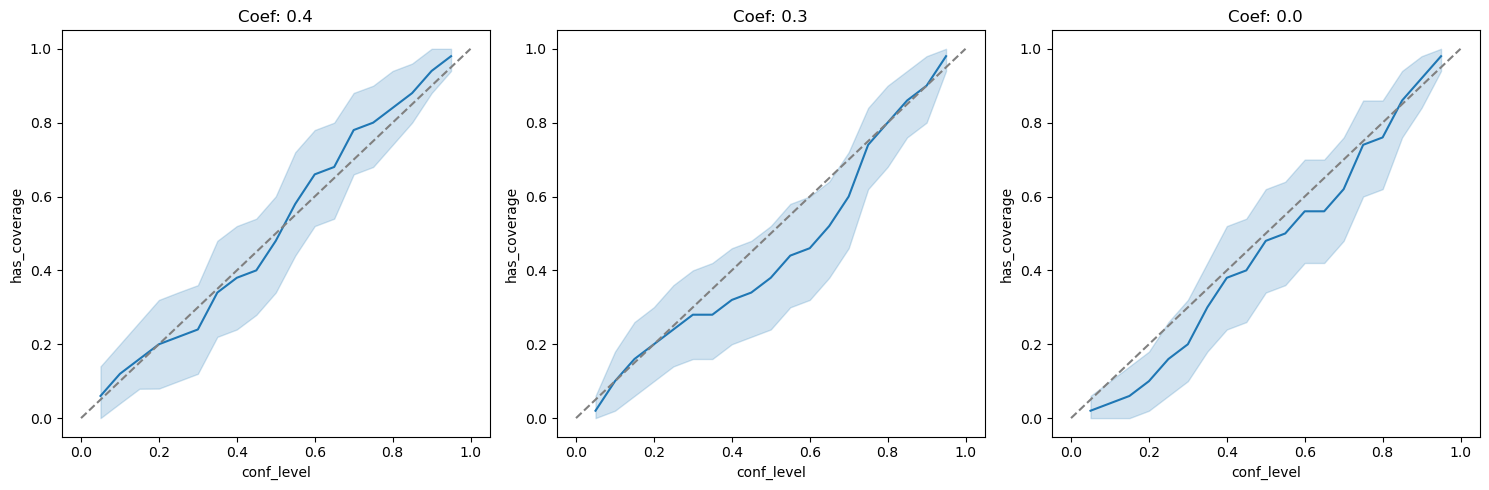

In [6]:
fig, axes = plt.subplots(1, d - 1, figsize=(5 * (d - 1), 5))
for i in range(d - 1):
    cdf = df[df.dim == i]
    ax = axes[i]
    sns.lineplot(data=cdf, x="conf_level", y="has_coverage", ax=ax)
    ax.plot((0, 1), (0, 1), linestyle="dashed", color="grey")
    ax.set_title("Coef: {}".format(true_params[i].item()))

plt.tight_layout()
plt.show()